
# MovieLense Rating Data
<p>CSCA-5632 Unsupervised Algorithms in Machine Learning</p>
<p>University of Colorado Boulder</p>
<p>@author alme9155@colorado.edu</p>
<hr/>

<h2>I. Project Overview:</h2>
<h3>I.i.Objectives</h3>
<h3>Use Matrix factorization technique(s) and predict the missing ratings from the test data. Measure the RMSE.</h3> 

This notebook includes the following:
* Brief EDA procedures
* Matrix factorization model building and training
* Model predictions and RMSE results
* Prediction results comparison with Supervised Learning
* Improvement from simple baseline.

<h3>I.ii. Project Description</h3>
This project will use a MovieLense rating dataset to run matrix factorization model building and return prediction results with root mean square error (RMSE). 
<ul>
<li>Data source: <a url="https://www.kaggle.com/odedgolden/movielens-1m-dataset">https://www.kaggle.com/odedgolden/movielens-1m-dataset</a></li>
<li>MovieLens 1M</li>
</ul>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movies-len-1m/movies.csv
/kaggle/input/movies-len-1m/users.csv
/kaggle/input/movies-len-1m/train.csv
/kaggle/input/movies-len-1m/test.csv


<h2>II. Exploratory Data Analysis</h2>

<h3>II.i.Loading the data from class CSV files</h3>
This notebook includes CSV files from week3 assignment. 

<h3>II.ii.Exploring and understanding the data</h3>
Explore dataset structure.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 
from pytest import approx
# EDA process
# 1. load the dataset
# 2. inspect the data

## loading the data
MV_users = pd.read_csv('/kaggle/input/movies-len-1m//users.csv')
MV_movies = pd.read_csv('/kaggle/input/movies-len-1m//movies.csv')
train = pd.read_csv('/kaggle/input/movies-len-1m//train.csv')
test = pd.read_csv('/kaggle/input/movies-len-1m//test.csv')
print(f"Data loaded successfully.")

print(f"\nTraining Data Info:")
print("--------------------------")
print(train.info())
print(f"\nTesting Data Info:")
print("--------------------------")    
print(test.info())

print(f"\nFirst five rows of training data:")
print("--------------------------")    
print(train.head())
print(f"\nFirst five rows of testing data:")
print("--------------------------")    
print(test.head())

print(f"\nMissing values in Training Set:")
print("--------------------------")    
print(train.isnull().sum())
print(f"\nMissing Values in Test Set:")
print("--------------------------")    
print(test.isnull().sum())

# print("\nArticle Categories")
# print("--------------------------")    
# unique_categories = train['Category'].unique()
# print(f"Unique Article categories:{unique_categories}")
# print(f"Number of categories:{len(unique_categories)}")

from collections import namedtuple
Data = namedtuple('Data', ['users','movies','train','test'])
data = Data(MV_users, MV_movies, train, test)

print("Resys class loaded.")

Data loaded successfully.

Training Data Info:
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700146 entries, 0 to 700145
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   uID     700146 non-null  int64
 1   mID     700146 non-null  int64
 2   rating  700146 non-null  int64
dtypes: int64(3)
memory usage: 16.0 MB
None

Testing Data Info:
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300063 entries, 0 to 300062
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   uID     300063 non-null  int64
 1   mID     300063 non-null  int64
 2   rating  300063 non-null  int64
dtypes: int64(3)
memory usage: 6.9 MB
None

First five rows of training data:
--------------------------
    uID   mID  rating
0   744  1210       5
1  3040  1584       4
2  1451  1293       5
3  5455  3176       2
4  2507  3074       5

First five rows o

<h3>II.iii.Create sample train and test dataset for quick debugging</h3>

In [3]:
# Creating Sample train data
np.random.seed(42)
sample_train = train[:30000]
sample_test = test[:30000]
sample_MV_users = MV_users[(MV_users.uID.isin(sample_train.uID)) | (MV_users.uID.isin(sample_test.uID))]
sample_MV_movies = MV_movies[(MV_movies.mID.isin(sample_train.mID)) | (MV_movies.mID.isin(sample_test.mID))]
sample_data = Data(sample_MV_users, sample_MV_movies, sample_train, sample_test)
print(f"Sample train and test dataset created successfully.")

Sample train and test dataset created successfully.


<h2>III. Enhance RecSys class with matrix factorization method</h2>

Enhance Recommendation System class from Week 3 assignment with new method to predict missing ratings from the the test data.

In [4]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

class RecSys():
    def __init__(self,data):
        self.data=data
        self.allusers = list(self.data.users['uID'])
        self.allmovies = list(self.data.movies['mID'])
        self.genres = list(self.data.movies.columns.drop(['mID', 'title', 'year']))
        self.mid2idx = dict(zip(self.data.movies.mID,list(range(len(self.data.movies)))))
        self.uid2idx = dict(zip(self.data.users.uID,list(range(len(self.data.users)))))
        self.Mr=self.rating_matrix()
        self.Mm=None 
        self.sim=np.zeros((len(self.allmovies),len(self.allmovies)))
        
    def rating_matrix(self):
        """
        Convert the rating matrix to numpy array of shape (#allusers,#allmovies)
        """
        ind_movie = [self.mid2idx[x] for x in self.data.train.mID] 
        ind_user = [self.uid2idx[x] for x in self.data.train.uID]
        rating_train = list(self.data.train.rating)
        
        return np.array(coo_matrix((rating_train, (ind_user, ind_movie)), shape=(len(self.allusers), len(self.allmovies))).toarray())


    def predict_everything_to_3(self):
        """
        Predict everything to 3 for the test data
        """
        # Generate an array with 3s against all entries in test dataset
        # your code here
        return np.full(len(self.data.test), 3.00)
        
        
    def predict_to_user_average(self):
        """
        Predict to average rating for the user.
        Returns numpy array of shape (#users,)
        """
        # Generate an array as follows:
        # 1. Calculate all avg user rating as sum of ratings of user across all movies/number of movies whose rating > 0
        # 2. Return the average rating of users in test data
        # your code here
        
        user_average_ratings = self.data.train[self.data.train['rating'] > 0].groupby('uID')['rating'].mean()
        predicted_rating = self.data.test['uID'].map(user_average_ratings)
        return predicted_rating
    
    def predict_from_sim(self,uid,mid):
        """
        Predict a user rating on a movie given userID and movieID
        """
        # Predict user rating as follows:
        # 1. Get entry of user id in rating matrix
        # 2. Get entry of movie id in sim matrix
        # 3. Employ 1 and 2 to predict user rating of the movie
        # your code here
        
        # using the hint given in the resource material:
        # . ...the sum of similarity scores for all the movies 
        # which were rated by the user-group (i.e. User_rating !=0)
        
        user_idx = self.uid2idx[uid]
        movie_idx = self.mid2idx[mid]
        
        user_ratings = self.Mr[user_idx]
        movie_similarities = self.sim[movie_idx]
        non_zero_ratings = user_ratings[user_ratings != 0]
        
        non_zero_similarities = movie_similarities[user_ratings != 0]

        if np.sum(non_zero_similarities) > 0:
            weighted_sum = np.dot(non_zero_ratings, non_zero_similarities)
            similarity_sum = np.sum(non_zero_similarities)
            predicted_rating = weighted_sum / similarity_sum
        else:
            if len(non_zero_ratings) > 0:
                predicted_rating = np.mean(non_zero_ratings) 
            else:
                predicted_rating = 3.0            
        return predicted_rating
    
    
    
    def predict(self):
        """
        Predict ratings in the test data. Returns predicted rating in a numpy array of size (# of rows in testdata,)
        """
        # your code here
        # no normalization needed because predict_from_sim already filter out zero values
        predicted_ratings = []
        for _, row in self.data.test.iterrows():
            predicted_result_from_sim = self.predict_from_sim(row['uID'] , row['mID'])
            predicted_ratings.append(predicted_result_from_sim)
            
            #user_avg = self.Mr[self.uid2idx[uid]].mean() 
            #normalized_predicted_rating = predicted_result_from_sim - user_avg
            #predicted_ratings.append(normalized_predicted_rating)            
        return np.array(predicted_ratings)
        
    
    def rmse(self,yp):
        yp[np.isnan(yp)]=3 #In case there is nan values in prediction, it will impute to 3.
        yt=np.array(self.data.test.rating)
        return np.sqrt(((yt-yp)**2).mean())


    def predict_from_matrix_factorization(self, model):
        """
        Predict ratings for the test set using matrix factorization model
        
        Parameters:
        model: A matrix factorization model 
        
        Returns:
        predicted_ratings: A numpy array of predicted ratings for the test set.
        """
        # Fit the model on the training rating matrix
        Mr = self.Mr
        user_matrix = model.fit_transform(Mr)      # Matrix (#users, #components)
        item_matrix = model.components_            # Matrix (#components, #movies)

        # Predict the full reconstructed ratings
        Mr_pred = np.dot(user_matrix, item_matrix)
        
        mean_rating = 3.0
        if self.data.train['rating'].size > 0:
            mean_rating = self.data.train['rating'].mean() 

        predicted_ratings = []
        for idx, row in self.data.test.iterrows():
            uid = row['uID']
            mid = row['mID']

            # Check if user and movie exist in training data
            yp = mean_rating
            if uid in self.uid2idx and mid in self.mid2idx:
                user_idx = self.uid2idx[uid]
                movie_idx = self.mid2idx[mid]
                yp = Mr_pred[user_idx, movie_idx]
                yp = np.clip(yp, 1, 5)

            predicted_ratings.append(yp)
        return np.array(predicted_ratings)

print(f"Enhanced RecSys with predict_from_matrix_factorization loaded.")

Enhanced RecSys with predict_from_matrix_factorization loaded.


In [5]:
# Content Based filtering and Collaborative filtering
class ContentBased(RecSys):
    def __init__(self,data):
        super().__init__(data)
        self.data=data
        self.Mm = self.calc_movie_feature_matrix()  
        
    def calc_movie_feature_matrix(self):
        """
        Create movie feature matrix in a numpy array of shape (#allmovies, #genres) 
        """
        # your code here
        movie_feature_matrix = self.data.movies[self.genres].values
        return csr_matrix(movie_feature_matrix)
    
    
    def calc_item_item_similarity(self):
        """
        Create item-item similarity using Jaccard similarity
        """
        # Update the sim matrix by calculating item-item similarity using Jaccard similarity
        # Jaccard Similarity: J(A, B) = |A∩B| / |A∪B| 
        # your code here
        # using functions in the scipy.spatial.distance to speed up calculation
        # jaccard similiarity = 1 - jaccard_distance 
        jaccard_distances = pdist(self.Mm.toarray(), 'jaccard')  
        self.sim = 1 - squareform(jaccard_distances)
        
                
class Collaborative(RecSys):            
    def calc_item_item_similarity(self, simfunction, *X):  
        """
        Create item-item similarity using similarity function. 
        X is an optional transformed matrix of Mr
        """    
        # General function that calculates item-item similarity based on the sim function and data inputed
        if len(X)==0:
            self.sim = simfunction()            
        else:
            self.sim = simfunction(X[0]) # *X passes in a tuple format of (X,), to X[0] will be the actual transformed matrix
            
    def cossim(self):    
        """
        Calculates item-item similarity for all pairs of items using cosine similarity (values from 0 to 1) on utility matrix
        Returns a cosine similarity matrix of size (#all movies, #all movies)
        """
        # Return a sim matrix by calculating item-item similarity for all pairs of items using Jaccard similarity
        # Cosine Similarity: C(A, B) = (A.B) / (||A||.||B||) 
        # your code here
        # Using the hint:
        #  "Impute the unrated entries in self.Mr to the user's average rating
        #.     then subtract by the user mean, call this matrix X."
        
        user_means = np.nanmean(np.where(self.Mr != 0, self.Mr, np.nan), axis=1, keepdims=True)
        Mr_imputed = np.where((self.Mr == 0), user_means, self.Mr)          
        Xr = Mr_imputed - user_means
        
        Xr = np.nan_to_num(Xr, nan=0.0)        
        Xr_sparse = csr_matrix(Xr.T)
        self.sim = 0.5 * (1+cosine_similarity(Xr_sparse))
        np.fill_diagonal(self.sim, 1)      
        Xr = Mr_imputed - user_means 
        if np.isnan(Xr).any():
            Xr = np.nan_to_num(Xr)

        num_items = Xr.shape[1]
        self.sim = np.zeros((num_items, num_items))
        for i in range(num_items):
            for j in range(i, num_items):
                if i == j:
                    self.sim[i, j] = 1
                else:
                    dist = cosine(self.Mr[:, i], self.Mr[:, j])
                    self.sim[i, j] = 1 - dist
                    self.sim[j, i] = 1 - dist
        self.sim = np.clip(self.sim, 0, 1)
        return self.sim

        
    def jacsim(self,Xr):
        """
        Calculates item-item similarity for all pairs of items using jaccard similarity (values from 0 to 1)
        Xr is the transformed rating matrix.
        """    
        # Return a sim matrix by calculating item-item similarity for all pairs of items using Jaccard similarity
        # Jaccard Similarity: J(A, B) = |A∩B| / |A∪B| 
        # your code here
        # ref: https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.spatial.distance.pdist.html
        Xr = csr_matrix(Xr)
        
        Xr = (Xr != 0).astype(int)
        jaccard_distances = pairwise_distances(Xr.T.toarray(), metric='jaccard')
        self.sim = 1 - jaccard_distances
        np.fill_diagonal(self.sim, 1)
        self.sim = np.clip(self.sim, 0, 1)
        return self.sim

print(f"Similiarity measure loaded.")

Similiarity measure loaded.


<h2>IV. Baseline and Similiarity Predictions</h2>

In [6]:
# From week 3 assignment
rs = RecSys(data)
yp_everything_to_3 = rs.predict_everything_to_3()
rmse_everything_to_3 = rs.rmse(yp_everything_to_3)
print(f"Predict Everything to 3: RMSE=:{rmse_everything_to_3}")
yp_to_user_average = rs.predict_to_user_average()
rmse_to_user_average = rs.rmse(yp_to_user_average)
print(f"Predict to User Average: RMSE=:{rmse_to_user_average}")


Predict Everything to 3: RMSE=:1.2585510334053043
Predict to User Average: RMSE=:1.0352910334228647


In [7]:

# Content based filtering
cb = ContentBased(data)
cb.calc_item_item_similarity()
yp_cb = cb.predict()
rmse_content_based = cb.rmse(yp_cb)
print(f"Predict using Content-based filtering: RMSE=:{rmse_to_user_average}")

# Collaborative filtering
# cosine similiarity
cf = Collaborative(data)
cf.calc_item_item_similarity(cf.cossim)
yp_cossim = cf.predict()
rmse_cosine = cf.rmse(yp_cossim)
print(f"Predict using Cosine Similiarity: RMSE=:{rmse_to_user_average}")

# jaccard similiarity 
Xr = cf.Mr.astype(int)
t0=time.perf_counter()
cf.calc_item_item_similarity(cf.jacsim,Xr)
t1=time.perf_counter()
time_sim = t1-t0
print('similarity calculation time',time_sim)
yp = cf.predict()
rmse_jasim = cf.rmse(yp)
print(f"Predict using Jaccard Similarity: RMSE=:{rmse_jasim}")

Predict using Content-based filtering: RMSE=:1.0352910334228647


/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


Predict using Cosine Similiarity: RMSE=:1.0352910334228647


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


similarity calculation time 414.55172994199995
Predict using Jaccard Similarity: RMSE=:0.9913535741888878


<h2>V. NMF Predictions with static hyper-parameter</h2>

In [8]:
# NMF prediction with n_component =20
from sklearn.decomposition import NMF

clf = NMF(n_components=20)
predicted_ratings = rs.predict_from_matrix_factorization(clf)
rmse_nmf_20 = rs.rmse(predicted_ratings)
print(f"Matrix Factorization (n_components=20): RMSE: {rmse_nmf_20:.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Matrix Factorization (n_components=20): RMSE: 2.538


<h2>VI. Hyper-parameter tuning</h2>

n_components = 5, RMSE = 2.609
n_components = 10, RMSE = 2.567
n_components = 15, RMSE = 2.545


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


n_components = 20, RMSE = 2.538


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


n_components = 30, RMSE = 2.536


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


n_components = 40, RMSE = 2.547


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


n_components = 50, RMSE = 2.552
Best RMSE value with NMF prediction(n_components = 30), RMSE = 2.536


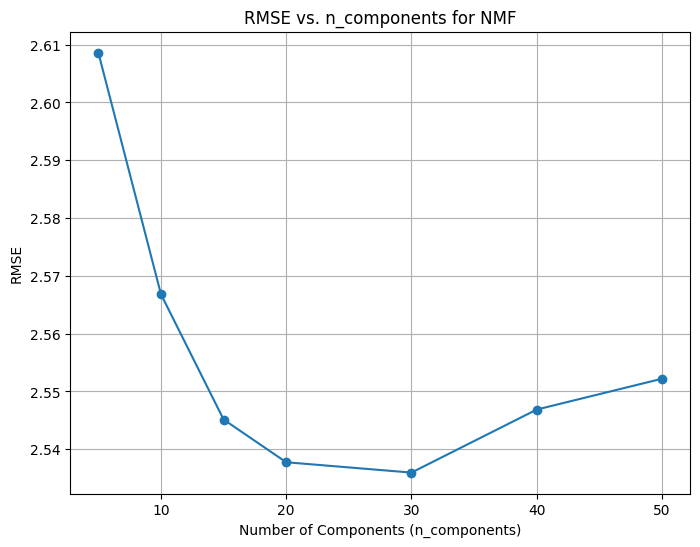

In [9]:
# hyper-parameter tuning to find best n_component, and lowest RMSE value
from sklearn.decomposition import NMF

n_component_values = [5, 10, 15, 20, 30, 40, 50]
rmse_values = []

best_nmf_comp =0
best_nmf_rmse= np.inf

for comp in n_component_values:
    clf = NMF(n_components=comp)
    predicted_ratings = rs.predict_from_matrix_factorization(clf)
    true_ratings = np.array(rs.data.test['rating'])
    rmse = rs.rmse(predicted_ratings)    
    print(f"n_components = {comp}, RMSE = {rmse:.3f}")
    if rmse < best_nmf_rmse:
        best_nmf_rmse = rmse
        best_nmf_comp = comp
    rmse_values.append(rmse)
    
print(f"Best RMSE value with NMF prediction(n_components = {best_nmf_comp}), RMSE = {best_nmf_rmse:.3f}")
plt.figure(figsize=(8,6))
plt.plot(n_component_values, rmse_values, marker='o')
plt.title('RMSE vs. n_components for NMF')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


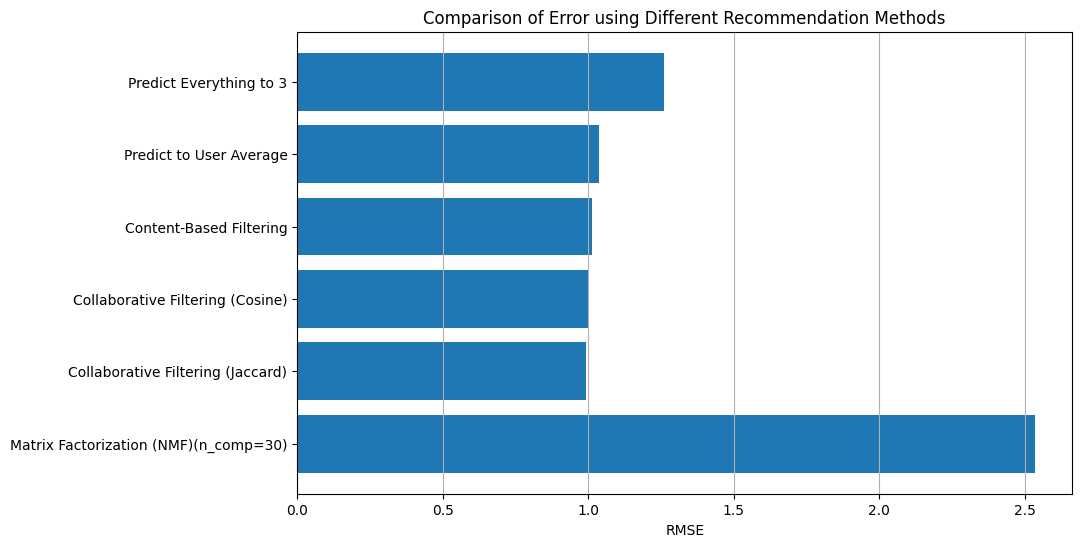

,Method,RMSE
0,Collaborative Filtering (Jaccard),0.991354
1,Collaborative Filtering (Cosine),1.002358
2,Content-Based Filtering,1.012503
3,Predict to User Average,1.035291
4,Predict Everything to 3,1.258551
5,Matrix Factorization (NMF)(n_comp=30),2.535923


In [10]:
# show comparison of RMSE vs Methods.
methods = [
    'Predict Everything to 3',
    'Predict to User Average',
    'Content-Based Filtering',
    'Collaborative Filtering (Cosine)',
    'Collaborative Filtering (Jaccard)',
    f"Matrix Factorization (NMF)(n_comp={best_nmf_comp})"
]

rmse_values = [
    rmse_everything_to_3,
    rmse_to_user_average,
    rmse_content_based,
    rmse_cosine,
    rmse_jasim, 
    best_nmf_rmse
]
rmse_df = pd.DataFrame({
    'Method': methods,
    'RMSE': rmse_values
})
rmse_df_sorted = rmse_df.sort_values('RMSE').reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.barh(methods, rmse_values)
plt.xlabel('RMSE')
plt.title('Comparison of Error using Different Recommendation Methods')
plt.gca().invert_yaxis() 
plt.grid(axis='x')
plt.show()

display(rmse_df_sorted)

<h2>VII. Conclusion</h2>

<p><b>Prediction results comparison using RMSE measure</b></p>

<p>Comparing the prediction results, unsupervised method using NMF performs significantly worse than other methods returns highest RMSE error.</p>
<p><b>Analysis: </b>Since the MovieLens-1M dataset is extremely sparse, the RMSE ~2.5 values suggest that the zeros values should be reconstructed as low values. Failing to ignore zeros during factorization can distort the learned latent factors.</p>
<p><b>Possible improvement: </b>If we mask out the components from the unknown values, prediction from NMF could be better. This could potentially be better than "everything to 3", but it will still be worse than a similarity-based method. </p>

@author alme9155@colorado.edu<br/>
@url: https://www.kaggle.com/code/ameau01/movierecommender-system-with-matrix-factorization

.